# Recommender
---

We have build a recommender based on purchase history. To obtain the top 5 recommendations for a specific user, type:

>```python top5recom.py [userId]```



By default, the files *functions.py*, *globvars.py* and *purchases.csv* should be in the same directory. Please read the full instructions of usage of the recommender typing the above command without the userId. If you want the recommender to output in stdout not only the recommended product Ids but also some intermidiate steps, please select *verb=True* in the file *options.py*.

The recommender uses a combination of:

- recommendations from a **collaborative filtering** algorithm (the alternating least squares algorithm for implicit feedback datasets from the Spark machine learning library, check it [here](http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html)).

- a **customized best-sellers** selection based on summary statistics after user segmentation.


### 1) How would you measure the performance of your recommender?

We evaluated our recommender testing its performance against the more recent 20% of purchases data (purchases after May 15, 2014) having trained it only with data before that date.

We measured its performance using two metrics:

- RMSE (root-mean-square error): this metric measures only the accuracy of our collaborative filtering algorithm predicting the "ratings" (0-1, 1 is a purchase) of the purchases on the test set (only 1s, only purchases).

- MAPK (mean average precision at k): on the other hand, MAPK compares our top 5 recommended products with the real future purchases on the test data. Considering the data and the goals that we have, we believe that **MAPK offers a much better measurment of the performance of our recommender**.


The computation of the MAPK can be very slow because the recommender must predict user ratings for all products. We found that calculating MAPK on a small sample of the users speeds up the computation and gives a very reasonable estimate of the real score. As a default, the algorithm randomly choses 1000 users, which gave us a mean deviation on the MAPK calculated in all the users of just 7%. This number can be choosen in options.py, changing ```num_u_toeval```.

To evaluate our recommender, just type:

>```python top5recom.py eval```

To speed up the computation, we set up an option *shorteval* (to be used in the above command instead of *eval*) that only uses 2014 data. It gives average higher scores. We don't recommend it because in a true environment you cannot ignore the evaluation of old users.

### 2) How does your approach compare to a trivial baseline?


We have defined a trivial baseline that always recommends the top 5 all-time best-sellers (removing already purchased products). For a specific user, obtain the baseline recommendations with:

>```python top5recom.py [userId] baseline```

The baseline can be evaluated (only MAPK computed) with:

>```python top5recom.py eval baseline```

Our recommender **improves the baseline, doubling its MAPK score**. This means that our recommender predicts twice the number of correct products (products that the user purchases in the test set).

We have also prepared a simpler version of our recommender that only considers user-customized best-sellers and does not include collaborative filtering. This model can be activated by typing *only_custom_BS* instead of *baseline* in the commands above. It already improves the MAPK baseline by a 50\%.

### 3) Provide the rationale for picking your specific algorithm.

As stated before, our algorithm combinies recommendations from collaborative filtering with user-segmented customized best-sellers. Compared to other possibilities, we picked this combination because of:

- **Accuracy**: it gives the best performance measured by MAPK,
- **Diversity**: adding customized best-sellers also ensures diversity, for example a user that bought a TV will not only be recommended with new TVs.

In general, **collaborative filtering** algorithms try to find *latent factors* (unknown features of the users and of the products) which allow us to predict the known *ratings* (in our cases purchases 0-1). As both user and product features are unknown, the algorithm minimizes the error on the predictions by finding the optimal parameters for users and products.

We selected this particular collaborative filtering algorithm of Spark MLlib ([this one](http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html)) because:

- being build in Spark, the approach is **scalable** to big data mantaining a fast speed.
- it includes an ***implicit feedback*** option that we have considered suitable to our problem. Instead of considering the user-item matrix as explicit preferences of the users, it treats the data as a combination of binary preferences and confidence values. The confidence on the purchase-as-rating can be customized (and grid-tunned) with the parameter *alpha*. The algortihm is based on [this article](http://yifanhu.net/PUB/cf.pdf).

The selection of the algorithm parameters was done **selecting the better performing model in a grid**. Our tunned parameters are (better combinations may exist):

- rank=25: number of latent factors in the model,
- iterations=30: number of iterations of ALS,
- lambda=0.01: regularization factor,
- alpha=60.: confidence parameter on the given ratings.

Regarding the **customized best-sellers**, the procedure is the following: we first segment the users depending on their purchase activity (users with at least 3 purchases in the last 3 months are labeled as 'active', the others are 'inactive' or 'new_users'), and then we recommend recent or not-so-recent best-sellers depending on this segmentation.

We also implemented two other features to improve the algorithm, which can be activated or deactivated in the *options.py* file. They give a 10% improvement on the score only if activated together:

- ***only_last_year***: True by default. If activated, the algorithm only trains on 2014 data, and users with no purchase on 2014 receive a best-sellers recommendation. It gives a small improvement on the score. This option is similar to *shorteval*, but shorteval only evaluates on 2014 data.

- ***remove_outliers***: True by default. Some users have more than 5k purchases, compared to the 1 or 2 of the majority of users. Thus, it may be that these super-buyers (outliers) are corrupting our collaborative filtering model. Presently, the algorithm removes those users with a number of purchases more than 7 standard deviations away form the mean. Further investigation is needed to optimize the number of outiers removed.

#### Possible improvements of our algorithm:

- We could extract product features from the productId, because the string contains groups of letters and numbers that may be related to product families (see the bottom of this notebook). That would allow us to add content-based recommendations and improve the **non-obviousness** of the recommender by adding recomendations from other product families.
- We could add previously purchased products in the recommendations. This improves the MAPK score, because users do purchase the same product twice.
- The evaluation procedure could be improved by adding:
    - cross-validation: tune parameters in the cv set, give score on the test set. We could test and cross-validate in April and May 2014 respectively, and train before these dates.
    - bagging: average the results from different seeds.
- The code speed can be improved by doing all the data analysis in spark instead of using pandas and then writting and reading an intermediate file. 
- The code architechture can be improved by using user/product/model classes.
- A thorough revision of the code is due to find possible errors.

## Exploration of the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("/data/storage/projects/Recomm/purchases.csv", sep=";", header=None,
                 names=["timestamp", "userId", "productId"])
print("total of %i rows, %i columns" % (df.shape[0],df.shape[1]))
df.head(2)

total of 2058178 rows, 3 columns


,timestamp,userId,productId
0,1331072795,4,AC016EL50CPHALID-1749
1,1331074425,1,AC016EL67BJWALID-932


### Explore purchases per user and per product

#### Descriptive statistics

In [3]:
print "**Num. purchases per productId**\n"
n_purch_per_product = pd.value_counts(df["productId"]).values
print pd.Series(n_purch_per_product).describe()

**Num. purchases per productId**

count    81903.000000
mean        25.129458
std        173.631492
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max      20302.000000
dtype: float64


Each product has been purchased an average of 25 times, with some products having over 20k purchases. The median of 4 is a good indicator of the number of times a product is usually purchased.

In [4]:
print "\n**Num. purchases per userId**\n"
n_purch_per_user = pd.value_counts(df["userId"]).values
print pd.Series(n_purch_per_user).describe()


**Num. purchases per userId**

count    699157.000000
mean          2.943799
std          13.673869
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        5460.000000
dtype: float64


Each user has purchased an average of 3 products times, with some users purchasing over 5k products. The median of 1 is a good indicator of the number of products a user usually purchases.

We may consider to remove frequent buyers so they don't dominate the model:

In [5]:
threshold = n_purch_per_user.mean() + 7*n_purch_per_user.std()
n_purch_per_user_f = n_purch_per_user[n_purch_per_user<threshold]
print("Outliers represent a %.2f%% of the users" % ((1.-len(n_purch_per_user_f)/float(len(df.userId.unique())))*100.))

Outliers represent a 0.06% of the users


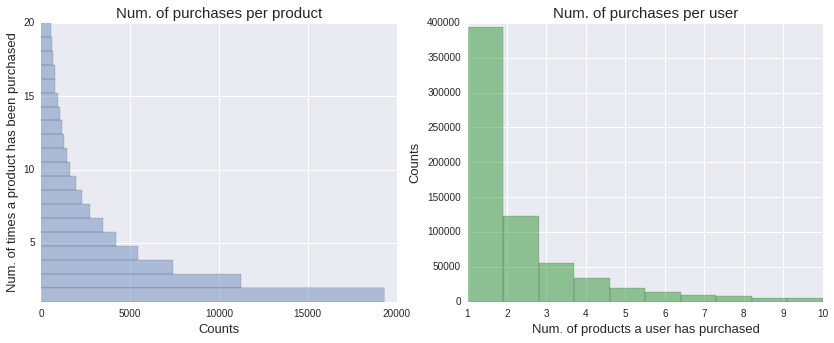

In [6]:
f, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(n_purch_per_product[n_purch_per_product<=20], kde=False, bins=20, ax=ax_l,
            vertical=True)
ax_l.set_ylim([1,20])
ax_l.set_title("Num. of purchases per product", fontsize=15)
ax_l.set_ylabel("Num. of times a product has been purchased", fontsize=13)
ax_l.set_xlabel("Counts", fontsize=13)
sns.distplot(n_purch_per_user[n_purch_per_user<=10], kde=False, bins=10, color='green', ax=ax_r)
ax_r.set_xlim([1,10])
ax_r.set_title("Num. of purchases per user", fontsize=15)
ax_r.set_xlabel("Num. of products a user has purchased", fontsize=13)
ax_r.set_ylabel("Counts", fontsize=13)

#### Top 10 products and users

In [7]:
Categ_cols = ["userId", "productId"]
for col in Categ_cols:
    df[col] = df[col].astype("category")
    n_un = len(df[col].unique())
    print '****************\n Feature: ',col,'\n****************'
    print 'Number of uniques:',n_un
    print 'Categories    Counts\n----------    ------'
    if n_un>10:
        print pd.value_counts(df[col])[:10],'\n (there are other %i categories not shown)' % (n_un-10)
    else:
        print pd.value_counts(df[col])
    print '\n'

****************
 Feature:  userId 
****************
Number of uniques: 699157
Categories    Counts
----------    ------
414519    5460
10946     3945
11369     3875
321933    3729
216295    2354
3444      2151
817015    1892
216293    1799
409184    1294
12054     1180
dtype: int64 
 (there are other 699147 categories not shown)


****************
 Feature:  productId 
****************
Number of uniques: 81903
Categories    Counts
----------    ------
SO888EL13MQGANID-45972     20302
IK617HLACKH6ANID-139943    13458
VI385HL03VBWANID-52960      8752
Q2536HLABPUOANID-88407      8061
MI417ELABNCNANID-84424      7525
PE668ELABTMEANID-96005      7373
QU463HBABN14ANID-83871      7156
BC680ELABJJOANID-78961      6753
AC016EL31IUMANID-63372      6410
SA848EL71ZSIANID-56257      6316
dtype: int64 
 (there are other 81893 categories not shown)




### Exploring time of purchases

In [8]:
df['datetime'] = pd.to_datetime(df["timestamp"], unit='s')
df.head(2)

,timestamp,userId,productId,datetime
0,1331072795,4,AC016EL50CPHALID-1749,2012-03-06 22:26:35
1,1331074425,1,AC016EL67BJWALID-932,2012-03-06 22:53:45


In [9]:
df.datetime.describe()

count                 2058178
unique                1488686
top       2012-06-23 14:05:41
freq                     3945
first     2012-03-06 22:26:35
last      2014-06-25 02:14:14
Name: datetime, dtype: object

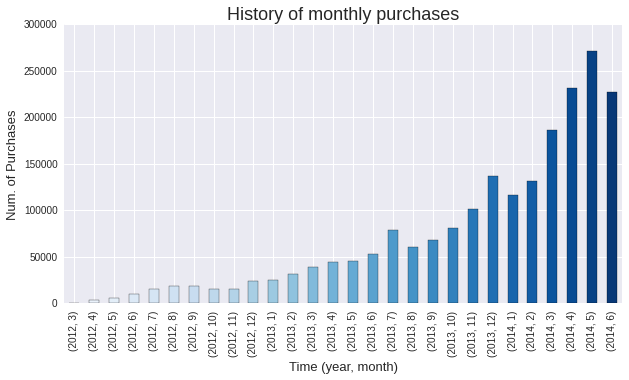

In [10]:
plt.figure(figsize=(10,5))
dfp = df['datetime'].groupby([df['datetime'].dt.year, df['datetime'].dt.month]).count()
p = dfp.plot(kind="bar", color=sns.color_palette("Blues", len(dfp)))
p.set_xlabel("Time (year, month)", fontsize=13)
p.set_ylabel("Num. of Purchases", fontsize=13)
p.set_title("History of monthly purchases", fontsize=18)

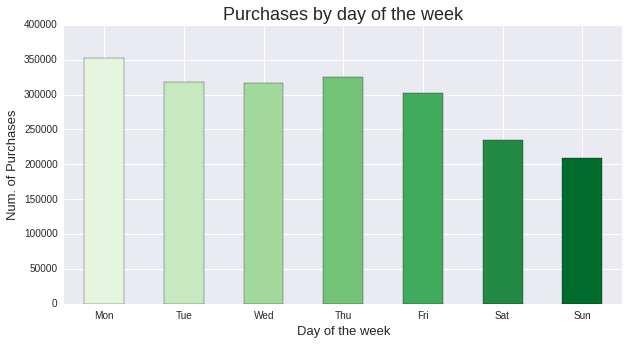

In [11]:
plt.figure(figsize=(10,5))
dfp = df['datetime'].groupby(df['datetime'].dt.dayofweek).count()
p = dfp.plot(kind="bar", color=sns.color_palette("Greens", len(dfp)))
p.set_xlabel("Day of the week", fontsize=13)
p.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)
p.set_ylabel("Num. of Purchases", fontsize=13)
p.set_title("Purchases by day of the week", fontsize=18)

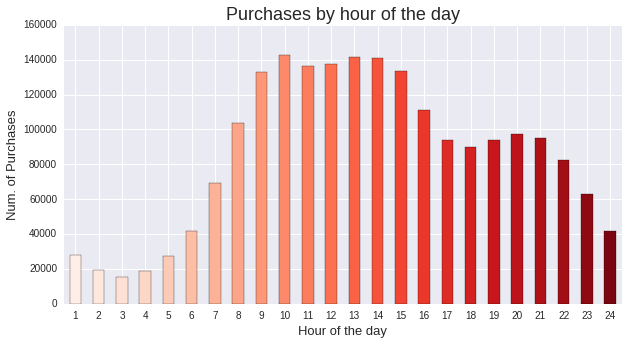

In [12]:
plt.figure(figsize=(10,5))
dfp = df['datetime'].groupby(df['datetime'].dt.hour).count()
p = dfp.plot(kind="bar", color=sns.color_palette("Reds", len(dfp)))
p.set_xlabel("Hour of the day", fontsize=13)
p.set_xticklabels(xrange(1,25), rotation=0)
p.set_ylabel("Num. of Purchases", fontsize=13)
p.set_title("Purchases by hour of the day", fontsize=18)

### Segmenting users by date of last purchase

We can segment users in three epochs:

- **2**: last purchase before this year (2014)
- **1**: last purchase before this month (June)
- **0**: last purchase in this month (June 2014)

In [13]:
# new dataframe with only the last purchase of each user:
df_lastp = df.ix[:,1:].sort_values('datetime').drop_duplicates(subset=['userId'],keep='last')

In [14]:
# create the feature "epoch"
df_lastp['year'], df_lastp['month'] = df_lastp.datetime.dt.year, df_lastp.datetime.dt.month
df_lastp['epoch'] = 2
df_lastp.loc[df_lastp['year'] == 2014,'epoch'] = 1
df_lastp.loc[(df_lastp['year'] == 2014) & (df_lastp['month'] >=6), 'epoch'] = 0
df_lastp.drop(['year','month'], axis=1, inplace=True)
df_lastp.head(2)

,userId,productId,datetime,epoch
0,4,AC016EL50CPHALID-1749,2012-03-06 22:26:35,2
29,16,VI962EL59EFGALID-2840,2012-03-09 15:33:59,2


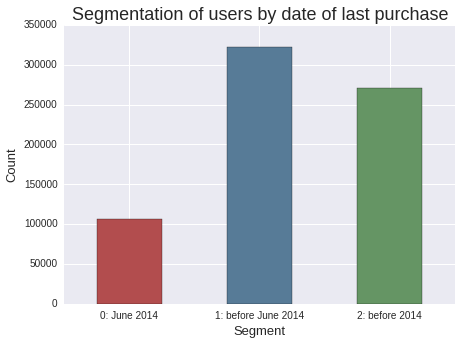

In [15]:
plt.figure(figsize=(7,5))
dfp = df_lastp.groupby('epoch')['epoch'].count()
p = dfp.plot(kind="bar", color=sns.color_palette("Set1", len(dfp), desat=.5))
p.set_xlabel("Segment", fontsize=13)
p.set_xticklabels(["0: June 2014", "1: before June 2014", "2: before 2014"], rotation=0)
p.set_ylabel("Count", fontsize=13)
p.set_title("Segmentation of users by date of last purchase", fontsize=18)

### Segmenting users by purchasing activity

It may be useful to segment our users by purchasing activity. A simple approach would be:

- **Active**: users that purchased at least 3 items in the last 3 months
- **Inactive**: the rest of users

In [16]:
date_3m_bef_last_purch = df.datetime.iloc[-1] + pd.tseries.offsets.DateOffset(months=-3)

In [17]:
# new dataframe with only the last purchase of each user:
df_lastp = df.ix[:,1:].sort_values('datetime').drop_duplicates(subset=['userId'],keep='last')
# First, to find the active users, drop those that did not bought during the last 3 months.
# (we saw before that the last date is 2014-06-25)
u_1p_last3m = df_lastp.ix[df.datetime>date_3m_bef_last_purch,:].userId.tolist()
df_u3m = df.ix[df.userId.isin(u_1p_last3m),1:]
# we remove the last purchase of each user from df_u3m, two times:
for i in xrange(2):
    df2rem = df_u3m.sort_values('datetime').drop_duplicates(subset=['userId'],keep='last')
    df2rem['key'] = 'x'
    df_u3m = pd.merge(df_u3m, df2rem, on=df_u3m.columns.tolist(), how='left')
    df_u3m = df_u3m[df_u3m['key'].isnull()].drop('key', axis=1)
# if the last purchase now is still within the last three months,
# then the user bought 3 items in the last 3 months:
df_u3m = df_u3m.sort_values('datetime').drop_duplicates(subset=['userId'],keep='last')
u_3p_last3m = df_u3m.ix[df_u3m.datetime>date_3m_bef_last_purch,:].userId.tolist()
print "Examples of active users: ",u_3p_last3m[-5:]

Examples of active users:  [377690, 38358, 960982, 150259, 374592]


In [18]:
df_activ = df.ix[df.userId.isin(u_3p_last3m),1:]
df_inact = df.ix[~df.userId.isin(u_3p_last3m),1:]

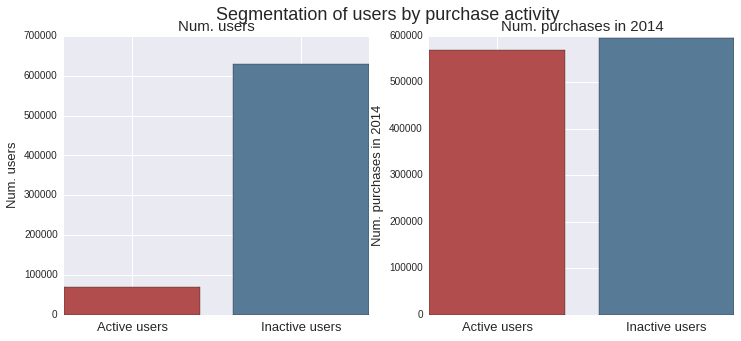

In [19]:
# plot segments:
f, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 5))
x = np.arange(2)
n_u = [len(df_activ.userId.unique()), len(df_inact.userId.unique())]
ax_l.bar(x, n_u, color=sns.color_palette("Set1", len(x), desat=.5))
ax_l.set_xticks(x + 0.4)
ax_l.set_xticklabels(["Active users", "Inactive users"], fontsize=13)
ax_l.set_ylabel("Num. users", fontsize=13)
ax_l.set_title("Num. users", fontsize=15)

n_p = [len(df_activ.ix[df_activ.datetime.dt.year==2014,:]),
       len(df_inact.ix[df_inact.datetime.dt.year==2014,:])]
ax_r.bar(x, n_p, color=sns.color_palette("Set1", len(x), desat=.5))
ax_r.set_xticks(x + 0.4)
ax_r.set_xticklabels(["Active users", "Inactive users"], fontsize=13)
ax_r.set_ylabel("Num. purchases in 2014", fontsize=13)
ax_r.set_title("Num. purchases in 2014", fontsize=15)
f.suptitle("Segmentation of users by purchase activity", fontsize=18)

### Best-sellers by time period

When being recommended with new products, our two segments of users may want to see different things:

- *Active users*: recommendations of recent products, very recent best-sellers
- *Inactive users*: add some all-time best sellers to the recommendations
- *New users*: mostly recommendations of all-time best-sellers

So now we will calculate the top 5 best-sellers of:

- all-time
- last 3 months
- last week

In [20]:
print("** The all-time top 5 purchased products are:")
top5_alltime = pd.value_counts(df["productId"])[:5]
print top5_alltime,"\n"
print("** The top 5 purchased products in the last 3 months are:")
print pd.value_counts(df.ix[df.datetime>"2014-03-25","productId"])[:5],"\n"
print("** The top 5 purchased products in the last week are:")
print pd.value_counts(df.ix[df.datetime>"2014-06-18","productId"])[:5],"\n"

** The all-time top 5 purchased products are:
SO888EL13MQGANID-45972     20302
IK617HLACKH6ANID-139943    13458
VI385HL03VBWANID-52960      8752
Q2536HLABPUOANID-88407      8061
MI417ELABNCNANID-84424      7525
dtype: int64 

** The top 5 purchased products in the last 3 months are:
IK617HLACKH6ANID-139943    13458
PE668ELABTMEANID-96005      6232
MO726ELADBYJANID-182332     5289
QU463HBABN14ANID-83871      4679
BO437ELABYHPANID-104585     3924
dtype: int64 

** The top 5 purchased products in the last week are:
IK617HLACKH6ANID-139943    1436
MO726ELADBYJANID-182332    1370
BO437ELABYHPANID-104585     662
TO970HLABWYMANID-101849     609
DE555EL38FQNANID-40153      601
dtype: int64 



### Possible new features for content-based recommendations

In [21]:
df["prod_1"] = df.productId.apply(lambda x: x.split("-")[0][:2])

In [22]:
df["prod_2"] = df.productId.apply(lambda x: x.split("-")[0][-4:])

In [23]:
df.head(2)

,timestamp,userId,productId,datetime,prod_1,prod_2
0,1331072795,4,AC016EL50CPHALID-1749,2012-03-06 22:26:35,AC,ALID
1,1331074425,1,AC016EL67BJWALID-932,2012-03-06 22:53:45,AC,ALID


In [24]:
Categ_cols = ["prod_1", "prod_2"]
n_max = 10
for col in Categ_cols:
    n_un = len(df[col].unique())
    print '****************\n Feature: ',col,'\n****************'
    print 'Number of uniques:',n_un
    print 'Categories    Counts\n----------    ------'
    if n_un>n_max:
        print pd.value_counts(df[col])[:n_max],'\n (there are other %i categories not shown)' % (n_un-n_max)
    else:
        print pd.value_counts(df[col])
    print '\n'

****************
 Feature:  prod_1 
****************
Number of uniques: 391
Categories    Counts
----------    ------
SA    145092
SO     68276
BL     64986
TO     58673
CA     54387
MO     51948
MA     50256
BC     48372
VI     45292
NA     39459
Name: prod_1, dtype: int64 
 (there are other 381 categories not shown)


****************
 Feature:  prod_2 
****************
Number of uniques: 833
Categories    Counts
----------    ------
ANID    2016098
ALID      39746
4LYF        100
4LJF         51
1QKW         21
1QHU         20
2LWT         20
3PTW         16
4PYB         16
0QAD         16
Name: prod_2, dtype: int64 
 (there are other 823 categories not shown)


